In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip



In [3]:
def cv2_show(name, image):
	
	cv2.imshow(name, image)
	cv2.waitKey(0)
	cv2.destroyWindow(name)

In [4]:
# 第一步：读入图片
image_path = 'test_images/test3.jpg'
image = cv2.imread(image_path)
cv2.imshow('image', image)
cv2.waitKey(0)


-1

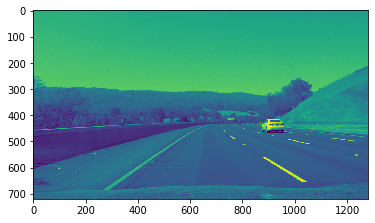

In [5]:
def grayscale(img):
        """
        将图像灰度化，作为后续边缘检测的预处理
        """
        return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
gray_img=grayscale(image)
plt.imshow(gray_img)


In [6]:
# 第二步：高斯平滑，去除噪声，canny边缘检测
def canny(img, ksize=(5,5), sigmaX=0, low_threshold=100, high_threshold=200):
	
	image = cv2.GaussianBlur(img, ksize, sigmaX)
	
	return cv2.Canny(image, low_threshold, high_threshold)

In [7]:

canny_img = canny(image)
cv2.imshow('canny_img', canny_img)
cv2.waitKey(0)


-1

In [8]:
# 第三步: 选定ROI, 对图像进行掩模操作，只显示ROI区域
def region_of_interest(img):
	height = img.shape[0]
	width = img.shape[1]
	region_of_interest_vertices = [(0, height),
	                               (width/2, height/2),
	                               (width, height)]
	mask = np.zeros_like(img)
	color = 255
	cv2.fillPoly(mask, np.array([region_of_interest_vertices], np.int32), color)
	mask_image = cv2.bitwise_and(img, mask)
	return mask_image


In [9]:
ROI_img = region_of_interest(canny_img)
cv2.imshow('ROI_img', ROI_img)
cv2.waitKey(0)

-1

In [10]:
# 第四步：hough变换，检测直线，并与原图混合
def hough_lines(img, rho=6, theta=np.pi/180, threshold=160, min_line_len=40, max_line_gap=25):
	
	lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
	                        maxLineGap=max_line_gap)
	
	return lines

def draw_lines(img, lines, color=[255,0,0], thickness=3):
	
	if lines is None:
		return 
	img = np.copy(img)
	img_channels = img.shape[2]
	line_img = np.zeros((img.shape[0], img.shape[1], img_channels), dtype=np.uint8)
	for line in lines:
		for x1, y1, x2, y2 in line:
			cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
	img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
	return line_img, img

In [11]:
lines = hough_lines(ROI_img)
line_img, img = draw_lines(image, lines)
cv2.imshow('line_img', line_img)
cv2.imshow('img', img)
cv2.waitKey(0)

-1

In [12]:
#第6步：直线拟合，根据端点画出左右lane

def group_line_and_draw(img, lines):
	
	left_x,left_y,right_x,right_y=[],[],[],[]
	for line in lines:
		for x1,y1,x2,y2 in line:
			slope=(y2-y1)/(x2-x1)
			if abs(slope)<0.5: continue
			if slope<0:
				left_x.extend([x1,x2])
				left_y.extend([y1,y2])
			if slope>0:
				right_x.extend([x1,x2])
				right_y.extend([y1,y2])
	min_y=int(img.shape[0]*(3/5))
	max_y=int(img.shape[0])
	poly_left = np.poly1d(np.polyfit(left_y,left_x,deg=1))
	left_x_start = int(poly_left(max_y))
	left_x_end = int(poly_left(min_y))
	poly_right = np.poly1d(np.polyfit(right_y,right_x,deg=1))
	right_x_start = int(poly_right(max_y))
	right_x_end = int(poly_right(min_y))
	line_image=draw_lines(img,[[
                [left_x_start,max_y,left_x_end,min_y],
                [right_x_start,max_y,right_x_end,min_y],          
                ]],thickness=5)
	return line_image



In [13]:
final_image = group_line_and_draw(image, lines)


cv2.imshow('result', final_image[1])
cv2.waitKey(0)

-1

In [14]:
def lane_img_pipeline(image):
	
	canny_img = canny(image)
	ROI_img = region_of_interest(canny_img)
	lines = hough_lines(ROI_img)
	line_img, img = draw_lines(image, lines)
	final_image = group_line_and_draw(image, lines)
	
	return final_image[1]

In [15]:
white_output='solidWhiteRight_output.mp4' #output文件名
clip1=VideoFileClip('project_video.mp4') #读入input video
print(clip1.fps) #frames per second 25, 默认传给write
white_clip=clip1.fl_image(lane_img_pipeline) #对每一帧都执行lane_img_pipeline函数，函数返回的是操作后的image
white_clip.write_videofile(white_output,audio=False) #输出经过处理后的每一帧图片，audio=false,不输出音频


OSError: MoviePy error: the file project_video.mp4 could not be found!
Please check that you entered the correct path.

NameError: name 'gray_image' is not defined

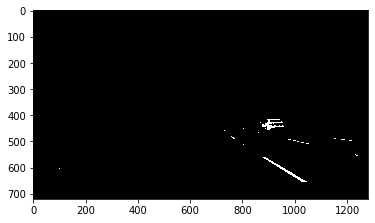

In [17]:
img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
cv2_show('img_hsv', img_hsv)
lower_yellow = np.array([20,100,100], dtype="uint8")
upper_yellow = np.array([50, 200, 200], dtype='uint8')

mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
cv2_show('mask_yellow', mask_yellow)

mask_white = cv2.inRange(gray_img, 200, 255)
cv2_show('mask_white', mask_white)

#或操作，将yellow与white合并
mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
plt.imshow(mask_yw,cmap='gray')
    
#与操作，将灰度图像淹膜处理，mask_yw以外的区域置零
mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)
plt.imshow(mask_yw_image,cmap='gray')